#EmoBerta Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        23
           1       0.67      0.52      0.59        23

    accuracy                           0.63        46
   macro avg       0.64      0.63      0.63        46
weighted avg       0.64      0.63      0.63        46


Confusion Matrix:
[[17  6]
 [11 12]]


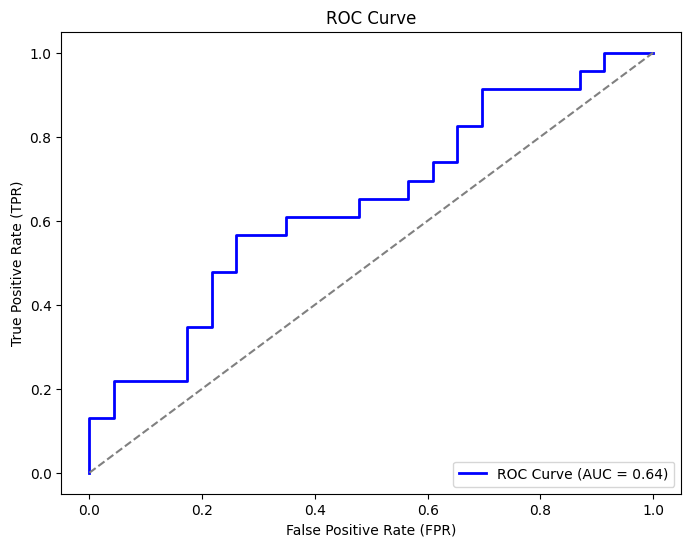

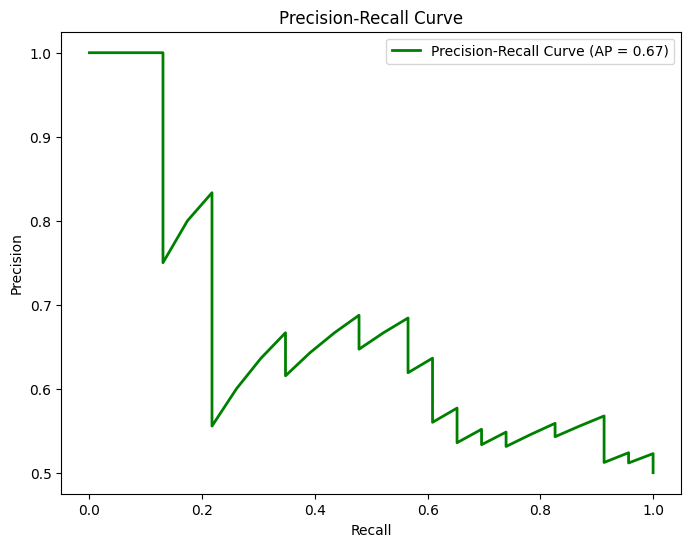

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenize the text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset
texts = df_balanced['text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base')
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(10):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
y_true, y_pred, y_pred_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
average_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

#EmoBerta using  Strafied Sampling

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.61      0.68        23
           1       0.68      0.83      0.75        23

    accuracy                           0.72        46
   macro avg       0.73      0.72      0.71        46
weighted avg       0.73      0.72      0.71        46


Confusion Matrix:
[[14  9]
 [ 4 19]]


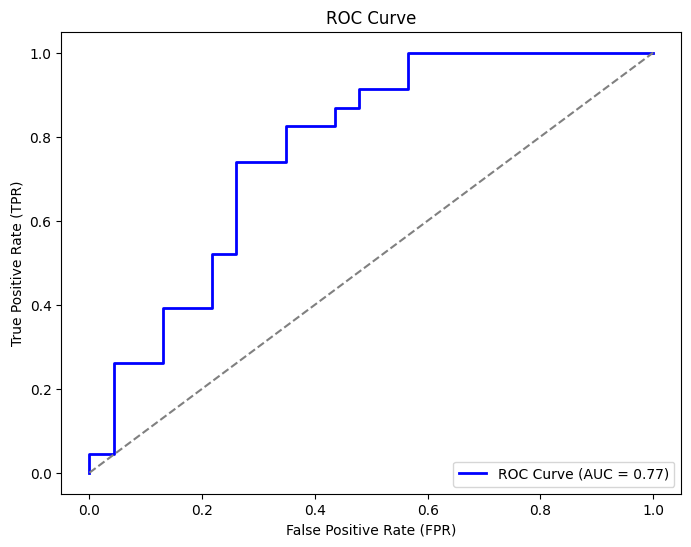

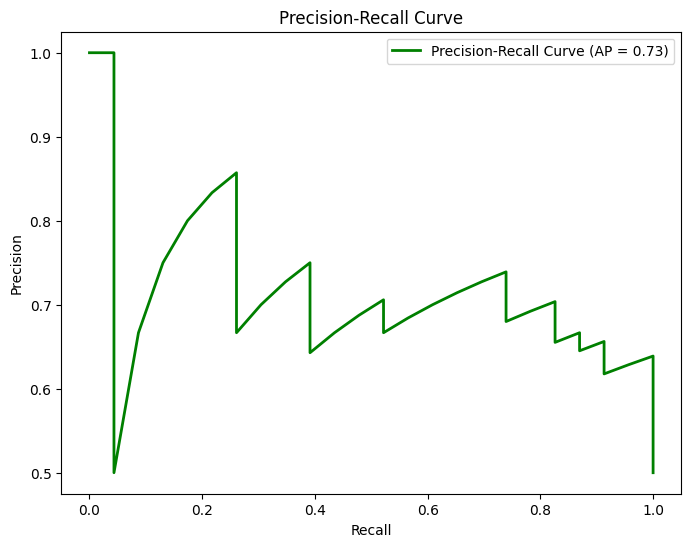

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Define a function to clean text
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove named entities
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenize the text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset
texts = df_balanced['cleaned_text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(10):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
y_true, y_pred, y_pred_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
average_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

#Calculate Expected Calibration Error: can be used to quantify how well a given model is calibrated e.g. how well the predicted output probabilities of the model matches the actual probabilities of the ground truth distribution

In [ ]:
def expected_calibration_error(y_true, y_pred_proba, n_bins=10):
    # Create bins for predicted probabilities
    bins = np.linspace(0, 1, n_bins + 1)

    bin_centers = (bins[:-1] + bins[1:]) / 2
    ece = 0.0
    total_samples = len(y_true)

    for i in range(n_bins):
        # Find indices of predicted probabilities that fall within the current bin
        bin_indices = np.where((y_pred_proba >= bins[i]) & (y_pred_proba < bins[i+1]))[0]
        if len(bin_indices) > 0:
            # Calculate the accuracy and average predicted probability for this bin
            bin_accuracy = np.mean(y_true[bin_indices] == 1)
            bin_avg_prob = np.mean(y_pred_proba[bin_indices])

            # Calculate calibration error for this bin
            bin_error = np.abs(bin_accuracy - bin_avg_prob)

            # Weight the error by the proportion of samples in this bin
            ece += len(bin_indices) / total_samples * bin_error

    return ece

# Calculate ECE
ece = expected_calibration_error(np.array(y_true), np.array(y_pred_proba), n_bins=10)
print(f"Expected Calibration Error (ECE): {ece:.4f}")


Expected Calibration Error (ECE): 0.2525


#Apply Isotonic Regression
###Isotonic regression is a non-parametric approach used for probability calibration, especially when the predicted probabilities are not well-calibrated (e.g., overconfident or underconfident). In our case, we used isotonic regression to improve the predicted probabilities output by the EmoBERTa model

ROC AUC (Platt Scaling): 0.77
ROC AUC (Isotonic Regression): 0.81

Classification Report (Platt Scaling):
              precision    recall  f1-score   support

           0       0.79      0.65      0.71        23
           1       0.70      0.83      0.76        23

    accuracy                           0.74        46
   macro avg       0.75      0.74      0.74        46
weighted avg       0.75      0.74      0.74        46


Classification Report (Isotonic Regression):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.74      0.74      0.74        23

    accuracy                           0.74        46
   macro avg       0.74      0.74      0.74        46
weighted avg       0.74      0.74      0.74        46



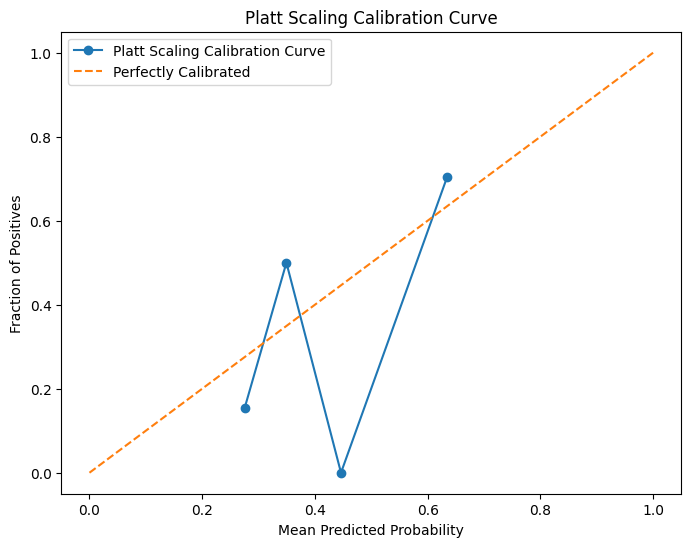

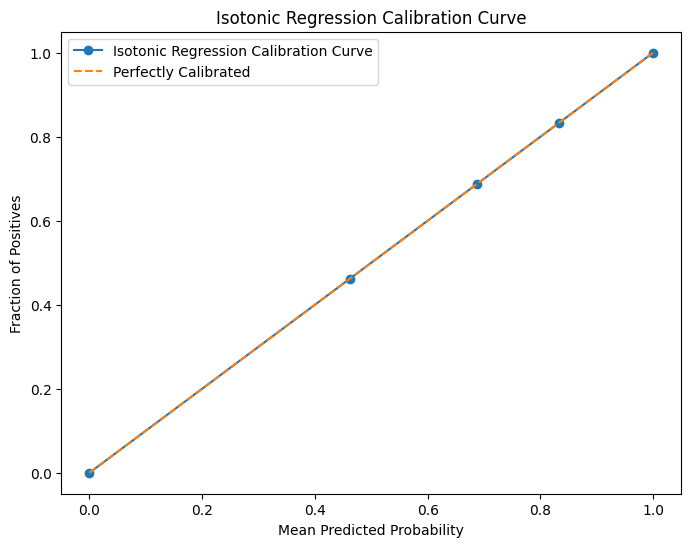

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt

# Assuming you already have y_true and y_pred_proba (probabilities for class 1)
# e.g., y_true and y_pred_proba from your existing evaluation block

# Method 1: Apply Platt Scaling (logistic regression based calibration)
def platt_scaling(y_true, y_pred_proba):
    from sklearn.linear_model import LogisticRegression

    # Fit a logistic regression to calibrate the predicted probabilities
    lr = LogisticRegression()
    lr.fit(y_pred_proba.reshape(-1, 1), y_true)

    # Calibrate probabilities
    calibrated_proba_platt = lr.predict_proba(y_pred_proba.reshape(-1, 1))[:, 1]

    return calibrated_proba_platt

# Method 2: Apply Isotonic Regression (non-parametric calibration)
def isotonic_regression_calibration(y_true, y_pred_proba):
    # Fit isotonic regression to the probabilities
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_pred_proba, y_true)

    # Calibrate probabilities
    calibrated_proba_iso = iso_reg.transform(y_pred_proba)

    return calibrated_proba_iso

# Calibrate using Platt Scaling
calibrated_proba_platt = platt_scaling(y_true, np.array(y_pred_proba))

# Calibrate using Isotonic Regression
calibrated_proba_iso = isotonic_regression_calibration(y_true, np.array(y_pred_proba))

# Now evaluate the performance of the calibrated probabilities

from sklearn.metrics import classification_report, roc_auc_score

# Check AUC for calibrated probabilities
roc_auc_platt = roc_auc_score(y_true, calibrated_proba_platt)
roc_auc_iso = roc_auc_score(y_true, calibrated_proba_iso)

print(f'ROC AUC (Platt Scaling): {roc_auc_platt:.2f}')
print(f'ROC AUC (Isotonic Regression): {roc_auc_iso:.2f}')

# Classification report for both methods
print("\nClassification Report (Platt Scaling):")
y_pred_platt = (calibrated_proba_platt > 0.5).astype(int)
print(classification_report(y_true, y_pred_platt))

print("\nClassification Report (Isotonic Regression):")
y_pred_iso = (calibrated_proba_iso > 0.5).astype(int)
print(classification_report(y_true, y_pred_iso))

# Plot Calibration Curves
def plot_calibration_curve(y_true, y_pred_proba, title='Calibration Curve'):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred_proba, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=title)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot calibration curves for both methods
plot_calibration_curve(y_true, calibrated_proba_platt, title='Platt Scaling Calibration Curve')
plot_calibration_curve(y_true, calibrated_proba_iso, title='Isotonic Regression Calibration Curve')


#Calculate Brier Score Loss:
###The Brier score measures the mean squared difference between the predicted probability and the actual outcome.

In [ ]:
from sklearn.metrics import brier_score_loss

# Compute Calibration Curves
fraction_of_positives_orig, mean_predicted_value_orig = calibration_curve(y_true, y_pred_proba, n_bins=10)
fraction_of_positives_iso, mean_predicted_value_iso = calibration_curve(y_true, calibrated_proba_iso, n_bins=10)

brier_score_orig = brier_score_loss(y_true, y_pred_proba)
brier_score_iso = brier_score_loss(y_true, calibrated_proba_iso)
print(brier_score_orig)
print(brier_score_iso)

0.24723349528768856
0.16292480437803888


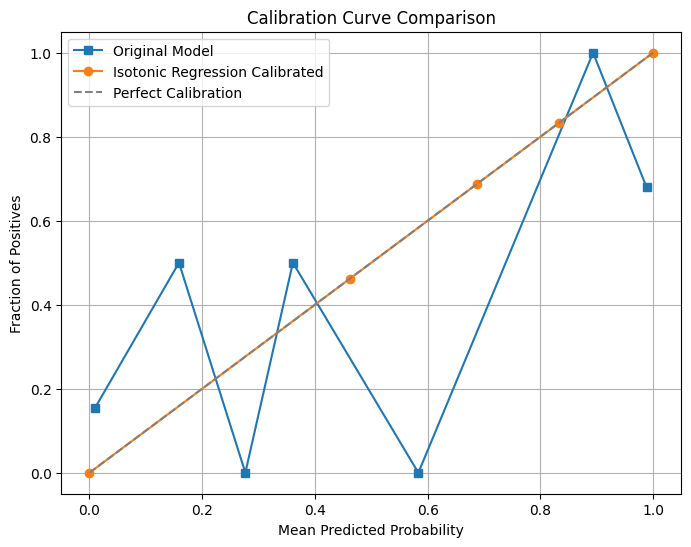

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value_orig, fraction_of_positives_orig, "s-", label="Original Model")
plt.plot(mean_predicted_value_iso, fraction_of_positives_iso, "o-", label="Isotonic Regression Calibrated")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

#Plot Calibration Plot

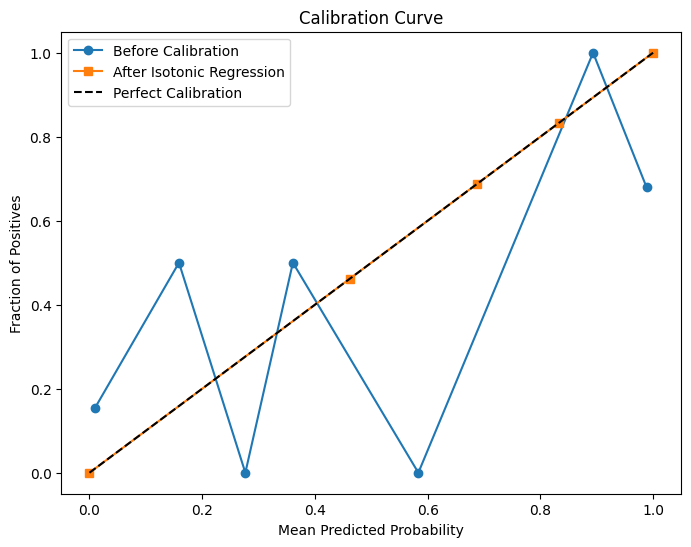

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_pred_proba, calibrated_proba_iso, title='Calibration Curve'):
    plt.figure(figsize=(8, 6))

    # Compute calibration curves
    fraction_of_positives_before, mean_predicted_value_before = calibration_curve(y_true, y_pred_proba, n_bins=10)
    fraction_of_positives_after, mean_predicted_value_after = calibration_curve(y_true, calibrated_proba_iso, n_bins=10)

    # Plot original model calibration
    plt.plot(mean_predicted_value_before, fraction_of_positives_before, marker='o', linestyle='-', label="Before Calibration")

    # Plot isotonic regression calibration
    plt.plot(mean_predicted_value_after, fraction_of_positives_after, marker='s', linestyle='-', label="After Isotonic Regression")

    # Perfectly calibrated line
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Calibration')

    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(title)
    plt.legend()
    plt.show()

# Call the function to plot calibration curves
plot_calibration_curve(y_true, y_pred_proba, calibrated_proba_iso)


#Upsampling Method:
 we applied the upsampling technique to the maladaptive class by resampling it with replacement until the number of samples in the maladaptive class was equal to the number of samples in the adaptive class. We then trained the EmoBERTa model on this newly balanced dataset.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    387
1    387
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96        78
           1       0.94      0.99      0.96        77

    accuracy                           0.96       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.96      0.96      0.96       155


Confusion Matrix:
[[73  5]
 [ 1 76]]


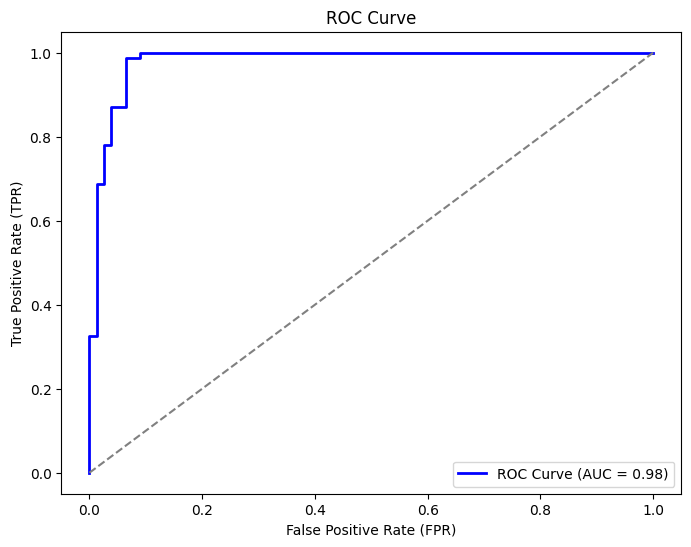

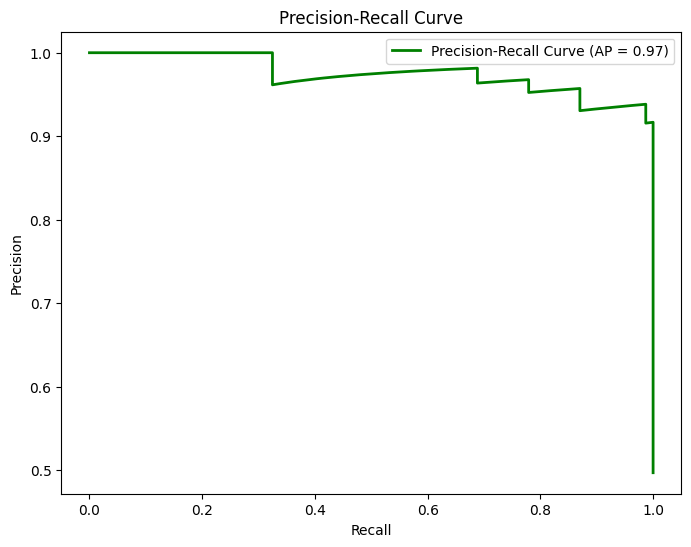

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Define a function to clean text
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)  # Remove named entities
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Upsample maladaptive to match adaptive count
maladaptive_upsampled = resample(maladaptive,
                                 replace=True,
                                 n_samples=len(adaptive),
                                 random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive, maladaptive_upsampled])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenize the text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset
texts = df_balanced['cleaned_text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(10):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
y_true, y_pred, y_pred_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

# Evaluate model
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
average_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


#HoldOut Set (For checking Model's Generalization)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.

Evaluation on Train Set:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        79
           1       0.93      1.00      0.96        79

    accuracy                           0.96       158
   macro avg       0.96      0.96      0.96       158
weighted avg       0.96      0.96      0.96       158



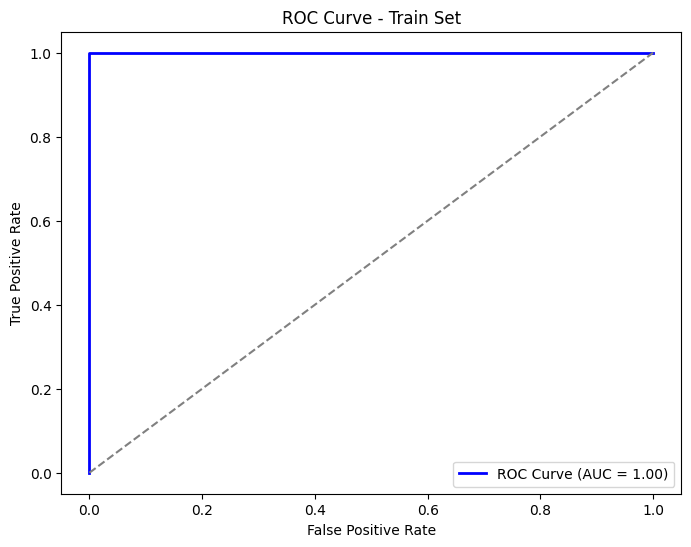

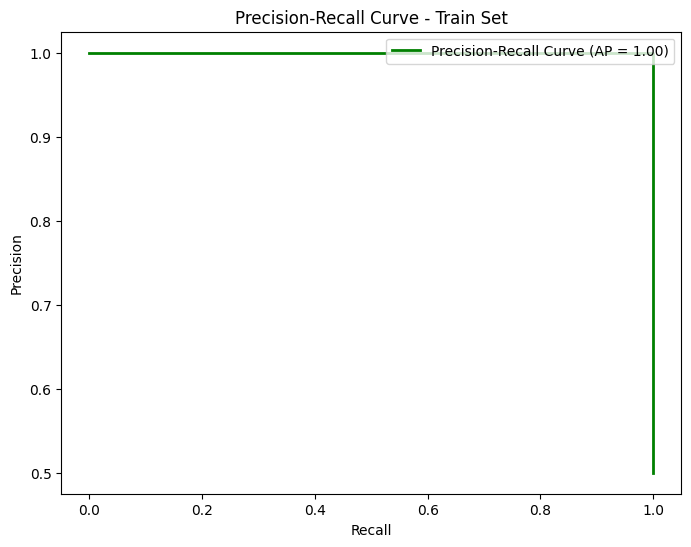


Evaluation on Validation Set:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47        22
           1       0.58      0.83      0.68        23

    accuracy                           0.60        45
   macro avg       0.62      0.59      0.57        45
weighted avg       0.62      0.60      0.58        45



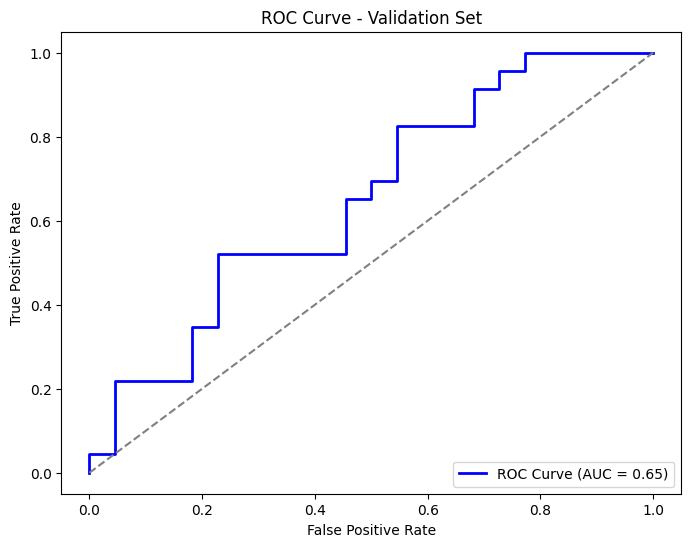

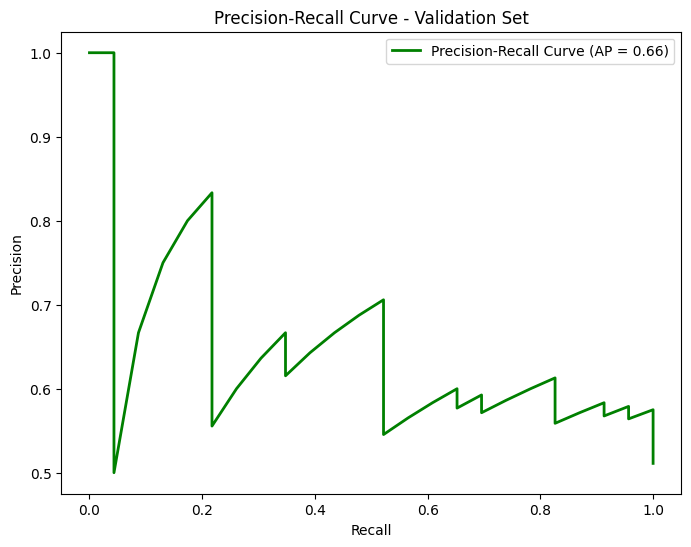


Evaluation on Holdout Set:
              precision    recall  f1-score   support

           0       0.80      0.33      0.47        12
           1       0.56      0.91      0.69        11

    accuracy                           0.61        23
   macro avg       0.68      0.62      0.58        23
weighted avg       0.68      0.61      0.58        23



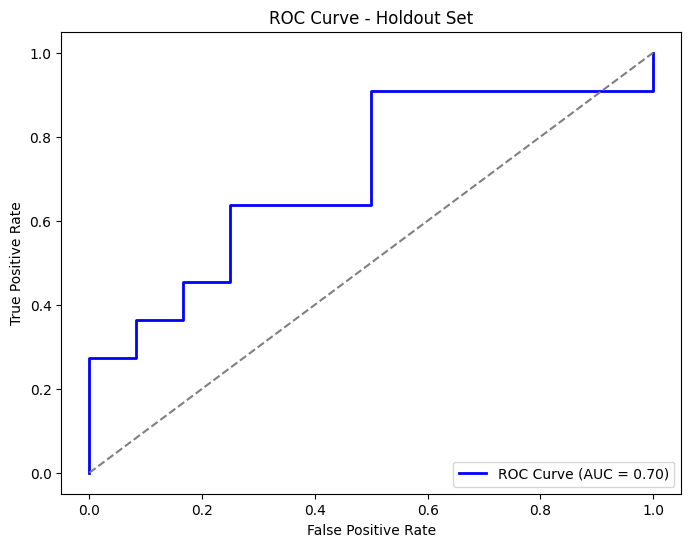

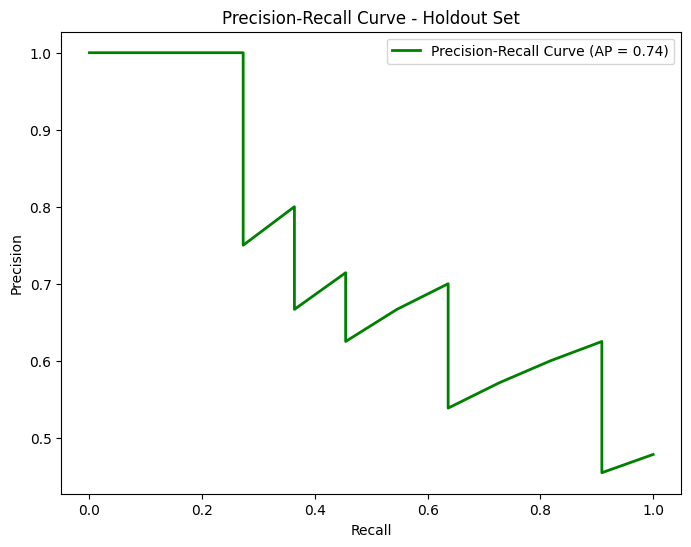

In [ ]:
import pandas as pd
import numpy as np
import re
import random
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Drive (if using Google Colab)
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Keep only relevant columns
df = df[['text_ner', 'Adaptive']]
df.columns = ['text', 'label']
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Downsample Adaptive Class to Balance the Dataset
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]
adaptive_downsampled = resample(adaptive, replace=False, n_samples=len(maladaptive), random_state=42)
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenization Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset
texts = df_balanced['text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into Train (70%), Validation (20%), and Holdout (10%)
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_holdout, y_val, y_holdout = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)
holdout_dataset = TextDataset(X_holdout, y_holdout, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
def train_model(model, train_loader, val_loader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{epochs} completed.")

# Train Model
train_model(model, train_loader, val_loader, optimizer, epochs=10)

# Evaluation Function
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_pred_proba = [], [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            probs = torch.softmax(logits, dim=1)[:, 1]

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

    return y_true, y_pred, y_pred_proba

# Evaluate on Train, Validation, and Holdout sets
for dataset_name, loader in zip(["Train", "Validation", "Holdout"], [train_loader, val_loader, holdout_loader]):
    print(f"\nEvaluation on {dataset_name} Set:")
    y_true, y_pred, y_pred_proba = evaluate_model(model, loader)
    print(classification_report(y_true, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name} Set')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name} Set')
    plt.legend(loc='upper right')
    plt.show()


#Emoberta model using Class weight method

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.

Evaluation on Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        79

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158



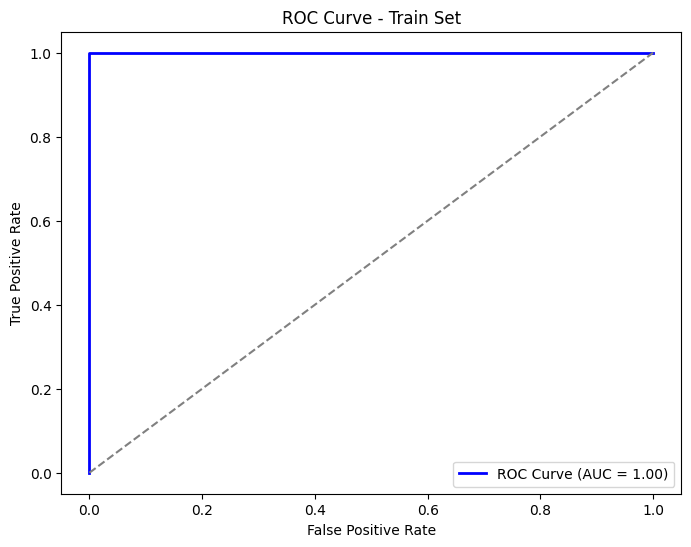

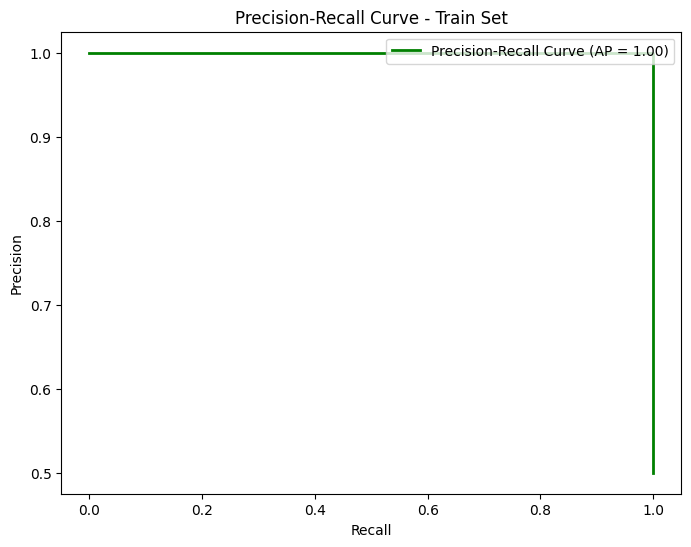


Evaluation on Validation Set:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68        22
           1       0.70      0.61      0.65        23

    accuracy                           0.67        45
   macro avg       0.67      0.67      0.67        45
weighted avg       0.67      0.67      0.67        45



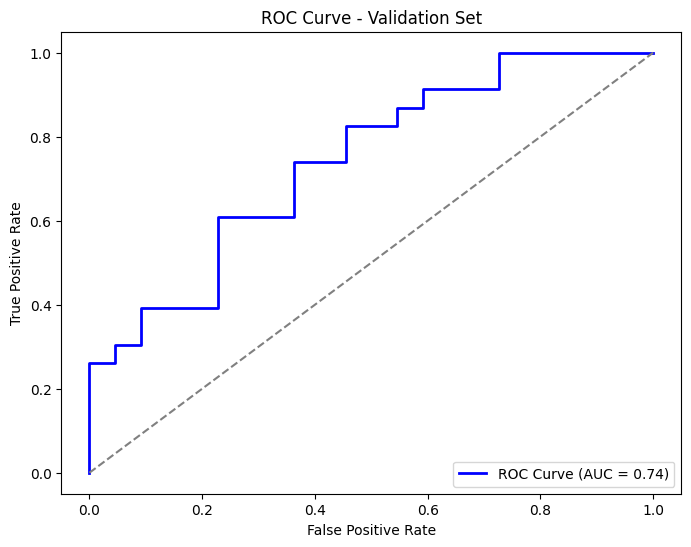

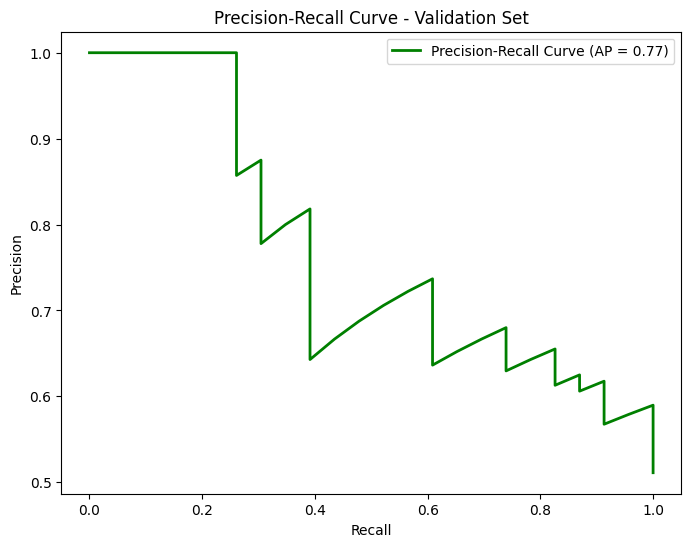


Evaluation on Holdout Set:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.62      0.73      0.67        11

    accuracy                           0.65        23
   macro avg       0.66      0.66      0.65        23
weighted avg       0.66      0.65      0.65        23



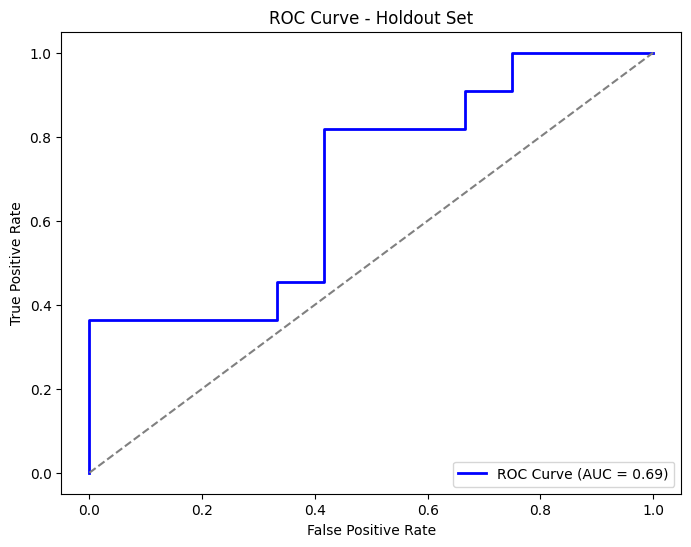

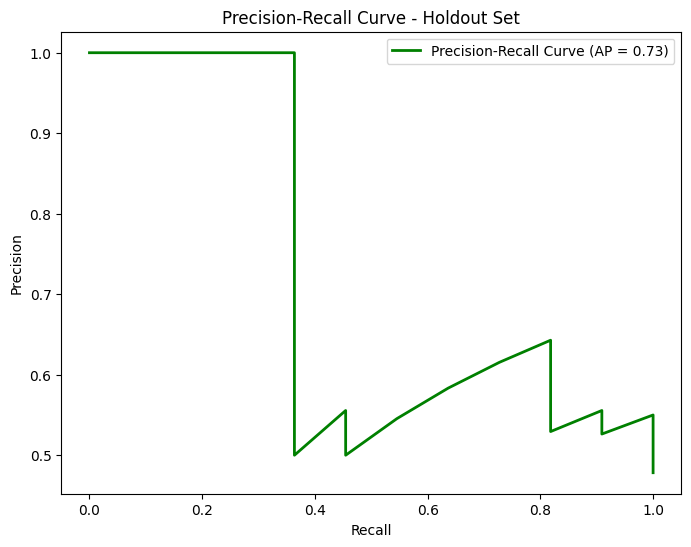

In [ ]:
import torch
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.utils import resample

# Mount Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Keep only relevant columns
df = df[['text_ner', 'Adaptive']]
df.columns = ['text', 'label']
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Downsample Adaptive Class to Balance the Dataset
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]
adaptive_downsampled = resample(adaptive, replace=False, n_samples=len(maladaptive), random_state=42)
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

# Load pre-trained EmoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Set Random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenization Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset
texts = df_balanced['text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into Train (70%), Validation (20%), and Holdout (10%)
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_holdout, y_val, y_holdout = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)
holdout_dataset = TextDataset(X_holdout, y_holdout, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=16, shuffle=False)

# Load pre-trained EmoBERTa model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

# Define optimizer with L2 regularization (weight decay)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)  # L2 regularization

# Focal Loss Implementation (for class imbalance)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)  # For each class, pt is p(t|x)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

# Training loop with Focal Loss
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{epochs} completed.")

# Train Model
focal_loss = FocalLoss(alpha=0.25, gamma=2)
train_model(model, train_loader, val_loader, optimizer, focal_loss, epochs=10)

# Evaluate Function
def evaluate_model(model, data_loader):
    model.eval()
    y_true, y_pred, y_pred_proba = [], [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            probs = torch.softmax(logits, dim=1)[:, 1]

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_pred_proba.extend(probs.cpu().numpy())

    return y_true, y_pred, y_pred_proba

# Evaluate on Train, Validation, and Holdout sets
for dataset_name, loader in zip(["Train", "Validation", "Holdout"], [train_loader, val_loader, holdout_loader]):
    print(f"\nEvaluation on {dataset_name} Set:")
    y_true, y_pred, y_pred_proba = evaluate_model(model, loader)
    print(classification_report(y_true, y_pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name} Set')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {dataset_name} Set')
    plt.legend(loc='upper right')
    plt.show()
